In [2]:
import zipfile
import os

zip_path = "/home/hanish-ch/Downloads/DATA SET.zip"
extract_to = "/home/hanish-ch/Downloads/smoking_dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

data_path = os.path.join(extract_to, "DATA SET")

In [3]:
import os

root = "/home/hanish-ch/Downloads/smoking_dataset"
for root_dir, dirs, files in os.walk(root):
    print("📁", root_dir)
    for d in dirs:
        print("   📂", d)
    for f in files:
        print("   📄", f)

📁 /home/hanish-ch/Downloads/smoking_dataset
   📂 DATA SET
📁 /home/hanish-ch/Downloads/smoking_dataset/DATA SET
   📂 Non-Smoker
   📂 Smokers
📁 /home/hanish-ch/Downloads/smoking_dataset/DATA SET/Non-Smoker
   📄 notsmoking_0202.jpg
   📄 notsmoking_0153.jpg
   📄 notsmoking_0532.jpg
   📄 notsmoking_0531.jpg
   📄 notsmoking_0053.jpg
   📄 notsmoking_0180.jpg
   📄 notsmoking_0538.jpg
   📄 notsmoking_0163.jpg
   📄 notsmoking_0521.jpg
   📄 notsmoking_0549.jpg
   📄 notsmoking_0032.jpg
   📄 notsmoking_0185.jpg
   📄 notsmoking_0130.jpg
   📄 notsmoking_0041.jpg
   📄 notsmoking_0533.jpg
   📄 notsmoking_0522.jpg
   📄 notsmoking_0056.jpg
   📄 notsmoking_0190.jpg
   📄 notsmoking_0085.jpg
   📄 notsmoking_0534.jpg
   📄 notsmoking_0004.jpg
   📄 notsmoking_0116.jpg
   📄 notsmoking_0124.jpg
   📄 notsmoking_0525.jpg
   📄 notsmoking_0147.jpg
   📄 notsmoking_0504.jpg
   📄 notsmoking_0500.jpg
   📄 notsmoking_0509.jpg
   📄 notsmoking_0133.jpg
   📄 notsmoking_0104.jpg
   📄 notsmoking_0062.jpg
   📄 notsmoking_0095.

In [5]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os

IMG_SIZE = (160, 160)
CLASSES = ["Smokers", "Non-Smoker"]
data_path = "/home/hanish-ch/Downloads/smoking_dataset/DATA SET"

images = []
labels = []

for idx, class_name in enumerate(CLASSES):
    folder_path = os.path.join(data_path, class_name)
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        try:
            img = load_img(file_path, target_size=IMG_SIZE)
            img_array = img_to_array(img) / 255.0
            images.append(img_array)
            labels.append(idx)
        except Exception as e:
            print(f"Skipped: {file_path} — {e}")

images = np.array(images)
labels = np.array(labels)

print("Loaded images:", len(images))
print("Label distribution:", np.bincount(labels))


Loaded images: 127
Label distribution: [66 61]


In [6]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [7]:
import tensorflow as tf

def get_model():
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(*IMG_SIZE, 3),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False  

    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation='sigmoid')  
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [8]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow.keras.backend as K

fold = 1
accuracies = []

for train_idx, val_idx in kf.split(images):
    print(f"\n Training Fold {fold}")

    x_train, x_val = images[train_idx], images[val_idx]
    y_train, y_val = labels[train_idx], labels[val_idx]

    model = get_model()

    model.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        epochs=10,
        batch_size=8,
        verbose=2,
        callbacks=[tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)]
    )

    # Evaluate
    y_pred = (model.predict(x_val) >= 0.5).astype(int).flatten()
    acc = accuracy_score(y_val, y_pred)
    accuracies.append(acc)

    print(f"Fold {fold} Accuracy: {acc:.4f}")
    print("Classification Report:\n", classification_report(y_val, y_pred, target_names=CLASSES))
    print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))

    # Save model
    model.save(f"/home/hanish-ch/Downloads/mobilenetv2_fold{fold}.h5")

    # Clear session
    K.clear_session()
    fold += 1


 Training Fold 1


2025-07-15 10:33:59.943689: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/10
13/13 - 7s - 504ms/step - accuracy: 0.5743 - loss: 0.7084 - val_accuracy: 0.7692 - val_loss: 0.5209
Epoch 2/10
13/13 - 1s - 113ms/step - accuracy: 0.7822 - loss: 0.4088 - val_accuracy: 0.7692 - val_loss: 0.4425
Epoch 3/10
13/13 - 1s - 93ms/step - accuracy: 0.9109 - loss: 0.2269 - val_accuracy: 0.8077 - val_loss: 0.5230
Epoch 4/10
13/13 - 1s - 86ms/step - accuracy: 0.9604 - loss: 0.1462 - val_accuracy: 0.8077 - val_loss: 0.5232
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Fold 1 Accuracy: 0.7692
Classification Report:
               precision    recall  f1-score   support

     Smokers       0.77      0.77      0.77        13
  Non-Smoker       0.77      0.77      0.77        13

    accuracy                           0.77        26
   macro avg       0.77      0.77      0.77        26
weighted avg       0.77      0.77      0.77        26

Confusion Matrix:
 [[10  3]
 [ 3 10]]

 Training Fold 2
Epoch 1/10
13/13 - 7s - 511ms/step - accuracy: 0.6436 - loss: 0.6393 - val_accuracy: 0.7308 - val_loss: 0.6461
Epoch 2/10
13/13 - 1s - 105ms/step - accuracy: 0.8812 - loss: 0.3320 - val_accuracy: 0.8462 - val_loss: 0.5165
Epoch 3/10
13/13 - 1s - 96ms/step - accuracy: 0.9406 - loss: 0.1640 - val_accuracy: 0.8462 - val_loss: 0.4992
Epoch 4/10
13/13 - 1s - 80ms/step - accuracy: 0.9307 - loss: 0.1444 - val_accuracy: 0.6538 - val_loss: 0.7360
Epoch 5/10
13/13 - 1s - 73ms/step - accuracy: 0.9901 - loss: 0.0920 - val_accuracy: 0.7692 - val_loss: 0.5784
1/1 ━━━━━━━━━━━━━

Fold 2 Accuracy: 0.8462
Classification Report:
               precision    recall  f1-score   support

     Smokers       0.88      0.88      0.88        16
  Non-Smoker       0.80      0.80      0.80        10

    accuracy                           0.85        26
   macro avg       0.84      0.84      0.84        26
weighted avg       0.85      0.85      0.85        26

Confusion Matrix:
 [[14  2]
 [ 2  8]]

 Training Fold 3
Epoch 1/10
13/13 - 6s - 470ms/step - accuracy: 0.5686 - loss: 0.8860 - val_accuracy: 0.6000 - val_loss: 0.6677
Epoch 2/10
13/13 - 2s - 129ms/step - accuracy: 0.7647 - loss: 0.5179 - val_accuracy: 0.8400 - val_loss: 0.3671
Epoch 3/10
13/13 - 1s - 112ms/step - accuracy: 0.8431 - loss: 0.3407 - val_accuracy: 0.8000 - val_loss: 0.3967
Epoch 4/10
13/13 - 1s - 93ms/step - accuracy: 0.9118 - loss: 0.2532 - val_accuracy: 0.8800 - val_loss: 0.3260
Epoch 5/10
13/13 - 1s - 81ms/step - accuracy: 0.9412 - loss: 0.1871 - val_accuracy: 0.8800 - val_loss: 0.3427
Epoch 6/10
13/13

Fold 3 Accuracy: 0.8800
Classification Report:
               precision    recall  f1-score   support

     Smokers       0.82      1.00      0.90        14
  Non-Smoker       1.00      0.73      0.84        11

    accuracy                           0.88        25
   macro avg       0.91      0.86      0.87        25
weighted avg       0.90      0.88      0.88        25

Confusion Matrix:
 [[14  0]
 [ 3  8]]

 Training Fold 4
Epoch 1/10
13/13 - 6s - 474ms/step - accuracy: 0.6471 - loss: 0.7089 - val_accuracy: 0.6000 - val_loss: 0.8089
Epoch 2/10
13/13 - 1s - 111ms/step - accuracy: 0.8039 - loss: 0.3432 - val_accuracy: 0.7600 - val_loss: 0.5311
Epoch 3/10
13/13 - 1s - 95ms/step - accuracy: 0.9216 - loss: 0.1725 - val_accuracy: 0.7600 - val_loss: 0.5737
Epoch 4/10
13/13 - 1s - 86ms/step - accuracy: 0.9902 - loss: 0.0893 - val_accuracy: 0.8000 - val_loss: 0.5852
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Fold 4 Accuracy: 0.7600
Classification Report:
               precision    recall  f1-score   support

     Smokers       0.80      0.67      0.73        12
  Non-Smoker       0.73      0.85      0.79        13

    accuracy                           0.76        25
   macro avg       0.77      0.76      0.76        25
weighted avg       0.77      0.76      0.76        25

Confusion Matrix:
 [[ 8  4]
 [ 2 11]]

 Training Fold 5
Epoch 1/10
13/13 - 7s - 500ms/step - accuracy: 0.5882 - loss: 0.7683 - val_accuracy: 0.9200 - val_loss: 0.3440
Epoch 2/10
13/13 - 1s - 105ms/step - accuracy: 0.8725 - loss: 0.3616 - val_accuracy: 0.9200 - val_loss: 0.3356
Epoch 3/10
13/13 - 1s - 100ms/step - accuracy: 0.9020 - loss: 0.2655 - val_accuracy: 0.8800 - val_loss: 0.3917
Epoch 4/10
13/13 - 1s - 86ms/step - accuracy: 0.9608 - loss: 0.1698 - val_accuracy: 0.8800 - val_loss: 0.4140


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Fold 5 Accuracy: 0.9200
Classification Report:
               precision    recall  f1-score   support

     Smokers       0.91      0.91      0.91        11
  Non-Smoker       0.93      0.93      0.93        14

    accuracy                           0.92        25
   macro avg       0.92      0.92      0.92        25
weighted avg       0.92      0.92      0.92        25

Confusion Matrix:
 [[10  1]
 [ 1 13]]


In [9]:
print("\n🎯 K-Fold Accuracies:")
for i, acc in enumerate(accuracies, 1):
    print(f"Fold {i}: {acc:.4f}")
print(f"\n🏁 Average Accuracy: {np.mean(accuracies):.4f}")


🎯 K-Fold Accuracies:
Fold 1: 0.7692
Fold 2: 0.8462
Fold 3: 0.8800
Fold 4: 0.7600
Fold 5: 0.9200

🏁 Average Accuracy: 0.8351


In [10]:
model = tf.keras.models.load_model("/home/hanish-ch/Downloads/mobilenetv2_fold1.h5")

CLASS_NAMES = ["Smokers", "Non-Smoker"]

for i in range(5):  # change this range to view more
    pred = model.predict(np.expand_dims(images[i], axis=0))[0][0]
    label = CLASS_NAMES[1] if pred >= 0.5 else CLASS_NAMES[0]
    print(f"Image {i+1} predicted as → {label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Image 1 predicted as → Smokers
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Image 2 predicted as → Smokers
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Image 3 predicted as → Smokers
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Image 4 predicted as → Smokers
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Image 5 predicted as → Smokers


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


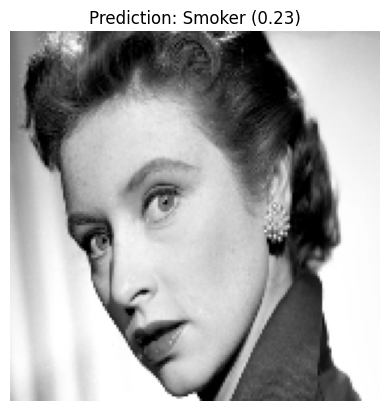

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


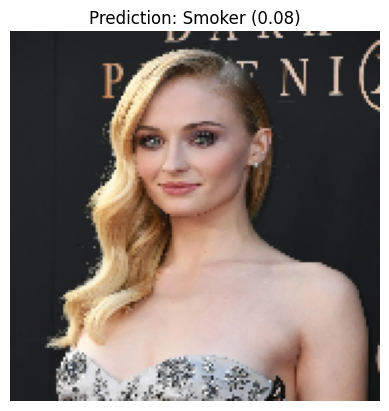

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


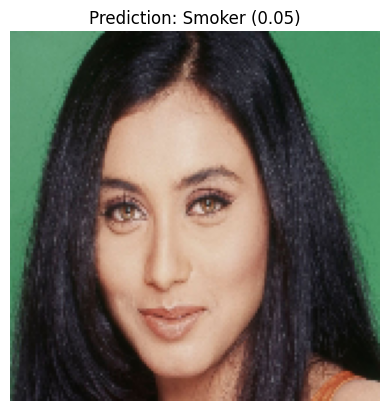

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


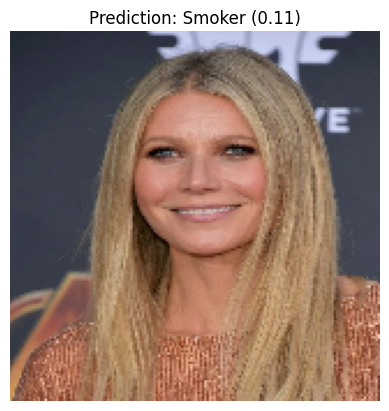

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


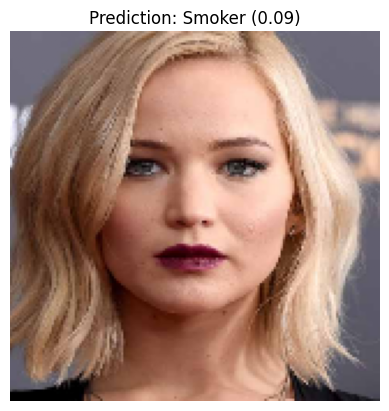

In [11]:
import matplotlib.pyplot as plt

sample_images = images[:5]  # pick any N samples

for i, img in enumerate(sample_images):
    pred = model.predict(np.expand_dims(img, axis=0))[0][0]
    label = "Non-Smoker" if pred >= 0.5 else "Smoker"
    
    plt.imshow(img)
    plt.title(f"Prediction: {label} ({pred:.2f})")
    plt.axis('off')
    plt.show()

In [12]:
pred_probs = model.predict(x_val).flatten()
pred_labels = (pred_probs >= 0.5).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [16]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_val, pred_labels)
print(f"Validation Accuracy: {accuracy:.2%}")

Validation Accuracy: 96.00%
